<a href="https://colab.research.google.com/github/Sadyk703/Practical_RL_1/blob/master/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Define actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

# Define critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ornstein-Uhlenbeck process for exploration noise
class OrnsteinUhlenbeckProcess:
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

# Define DDPG agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, lr_actor=1e-4, lr_critic=1e-3, gamma=0.99, tau=0.001):
        self.actor = Actor(state_dim, action_dim)
        self.actor_target = Actor(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma
        self.tau = tau
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.update_target_networks(tau=1.0)

        self.noise = OrnsteinUhlenbeckProcess(action_dim)

    def select_action(self, state, noise=True):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state).cpu().detach().numpy().squeeze(0)
        if noise:
            action += self.noise.sample()
        return np.clip(action, -1.0, 1.0)

    def update(self, replay_buffer, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(self.device)

        next_action = self.actor_target(next_state_batch)
        q_target_next = self.critic_target(next_state_batch, next_action)
        q_target = reward_batch + self.gamma * (1 - done_batch) * q_target_next

        q = self.critic(state_batch, action_batch)
        critic_loss = nn.functional.mse_loss(q, q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        policy_loss = -self.critic(state_batch, self.actor(state_batch)).mean()

        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.update_target_networks()

    def update_target_networks(self, tau=None):
        if tau is None:
            tau = self.tau
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

# Define a replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, Total Reward: -243.02
Episode: 1, Total Reward: -242.25
Episode: 2, Total Reward: -350.64
Episode: 3, Total Reward: -237.94
Episode: 4, Total Reward: -274.37
Episode: 5, Total Reward: -413.88
Episode: 6, Total Reward: -283.23
Episode: 7, Total Reward: -292.07
Episode: 8, Total Reward: -346.71
Episode: 9, Total Reward: -319.44
Episode: 10, Total Reward: -416.42
Episode: 11, Total Reward: -389.95
Episode: 12, Total Reward: -287.45
Episode: 13, Total Reward: -254.54
Episode: 14, Total Reward: -362.11
Episode: 15, Total Reward: -244.02
Episode: 16, Total Reward: -330.51
Episode: 17, Total Reward: -258.50
Episode: 18, Total Reward: -389.34
Episode: 19, Total Reward: -317.17
Episode: 20, Total Reward: -381.83
Episode: 21, Total Reward: -254.86
Episode: 22, Total Reward: -341.43
Episode: 23, Total Reward: -328.36
Episode: 24, Total Reward: -381.29
Episode: 25, Total Reward: -305.73
Episode: 26, Total Reward: -211.73
Episode: 27, Total Reward: -358.32
Episode: 28, Total Reward: -24

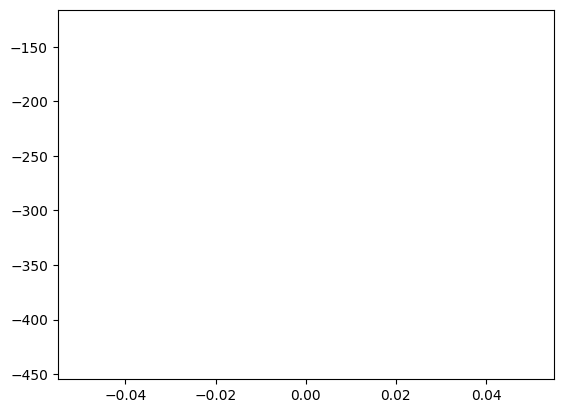

In [8]:
# Initialize environment and parameters
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = DDPGAgent(state_dim, action_dim)

# Initialize replay buffer
replay_buffer = ReplayBuffer(capacity=1000000)

# Training loop
max_episodes = 100
max_steps = 50
batch_size = 128

for episode in range(max_episodes):
    state = env.reset()
    agent.noise.reset()
    episode_reward = 0
    for step in range(max_steps):
        action = agent.select_action(state, noise=True)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        episode_reward += reward
        state = next_state
        if len(replay_buffer.buffer) > batch_size:
            agent.update(replay_buffer, batch_size)
        if done:
            break
    print("Episode: {}, Total Reward: {:.2f}".format(episode, episode_reward))
    plt.plot(episode_reward)